# Install Essential NLP Libraries in Kaggle

To get started with transformers, datasets, evaluation, and acceleration tools, run this:

```bash
!pip install transformers datasets evaluate accelerate peft


In [12]:
!pip install transformers datasets evaluate accelerate peft

# Import Required Libraries

In [13]:
import torch
from transformers import RobertaModel, RobertaTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import wandb
wandb.login(key="97c0d73ce3f332743f73aed9bfd6ffb011ebafb4")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
%matplotlib inline

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load AG News Dataset and Combine Splits ==

* Load the AG News dataset via the datasets library.
* Convert both training and test splits into pandas DataFrames.
* Concatenate these DataFrames into one full DataFrame.
* Enables easier and unified data analysis and processing.


In [14]:
dataset = load_dataset('ag_news')
df_1 = dataset['train'].to_pandas()
df_2 = dataset['test'].to_pandas()
df_full = pd.concat([df_1, df_2], ignore_index=True)

In [15]:
df_full.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [16]:
df_full.shape

(127600, 2)

#  Plot: Distribution of Labels in AG News Dataset 

- Create a figure with size 15x5 inches.
- Use seaborn's countplot to visualize counts of each 'label' in df_full.
- Apply the "Dark2" color palette for style.
- Add title: "Distribution of Labels in AG News Dataset".
- Label X-axis as "Label".
- Label Y-axis as "Count".
- Display the plot.


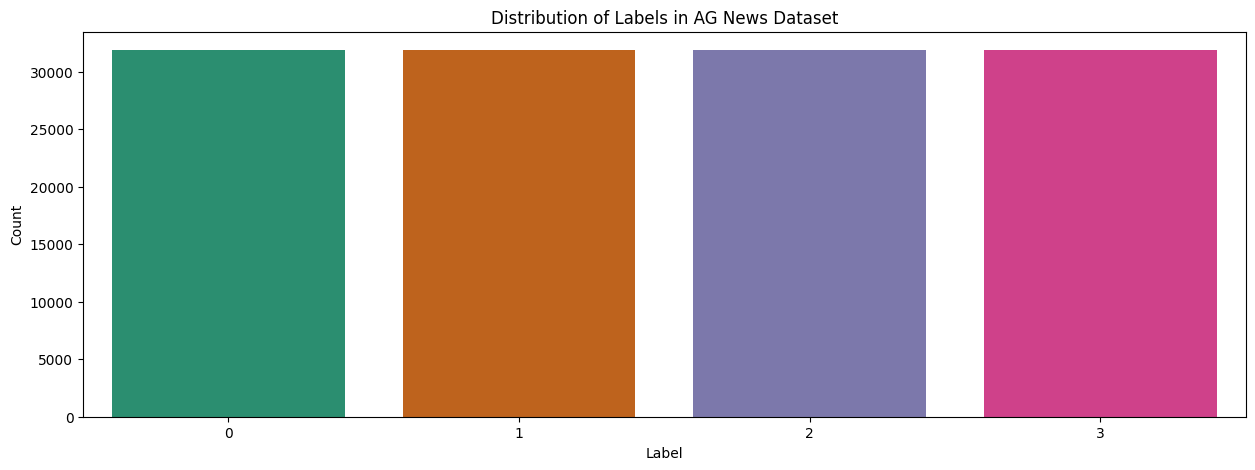

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(x='label', data=df_full,palette="Dark2")  

plt.title('Distribution of Labels in AG News Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualizing the Top 30 Most Common Words After Cleaning

1. Convert all text to lowercase for uniformity.
2. Define a function to tokenize the text, removing punctuation and filtering out stopwords and single-letter words.
3. Apply this cleaning function to the dataset’s text column.
4. Flatten the list of tokenized words for counting.
5. Count the frequency of each word using `Counter`.
6. Extract the 30 most common words.
7. Convert this data into a pandas DataFrame for plotting.
8. Use seaborn's barplot to visualize the word frequencies with a "Set1" color palette.
9. Set figure size, titles, and axis labels for clarity.
10. Display the plot showing the most frequent meaningful words in the dataset.


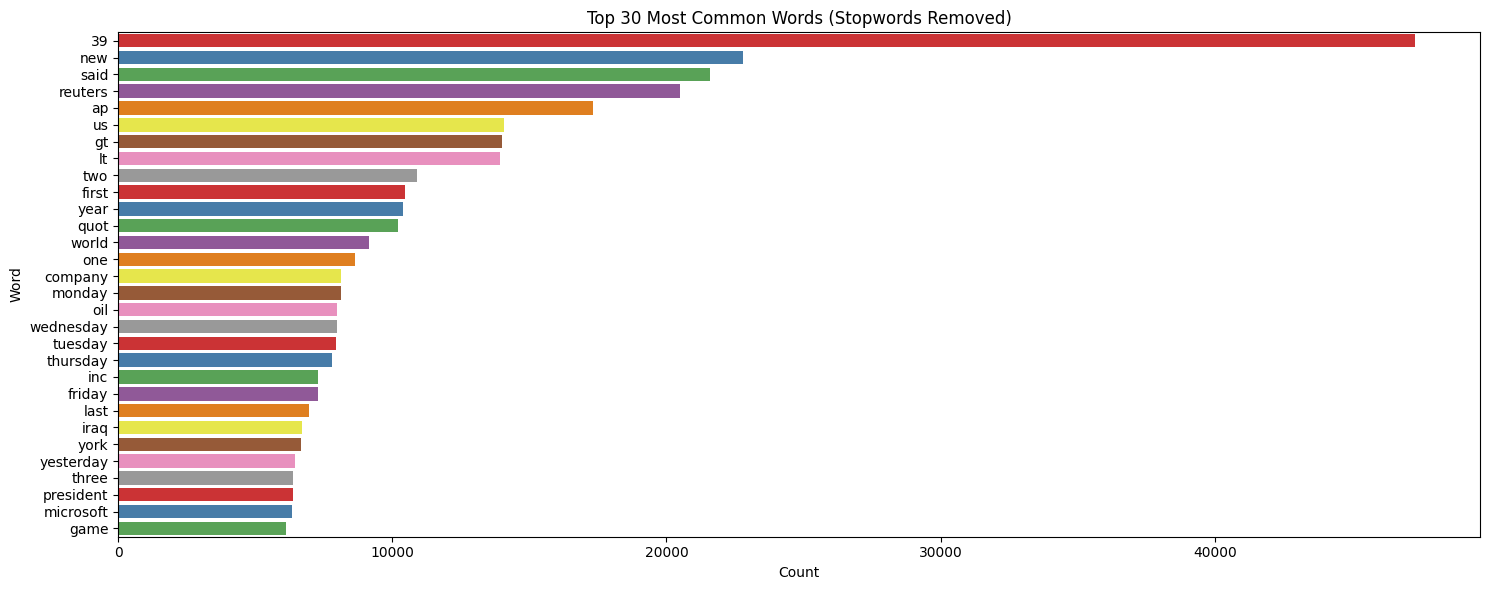

In [18]:
texts = df_full['text'].str.lower()

# Tokenize, clean, and remove stopwords
def clean_and_tokenize(text):
    words = re.findall(r'\b\w+\b', text)
    return [word for word in words if word not in stop_words and len(word) > 1]

words = texts.apply(clean_and_tokenize)
all_words = [word for sublist in words for word in sublist]

# Count frequencies
word_counts = Counter(all_words)
most_common_30 = word_counts.most_common(30)

# Create DataFrame for seaborn plot
df_words = pd.DataFrame(most_common_30, columns=['word', 'count'])

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(x='count', y='word', data=df_words,palette="Set1")
plt.title('Top 30 Most Common Words (Stopwords Removed)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Generating a Word Cloud of Top Words (Stopwords Removed)

- Join the cleaned list of words into a single string.
- Create a `WordCloud` object with specified width, height, and black background.
- Generate the word cloud from the combined text.
- Plot the word cloud with a large figure size for detail.
- Use bilinear interpolation for smooth rendering.
- Remove axis ticks for a clean look.
- Add a descriptive title with increased font size.
- Display the word cloud visualization to highlight the most frequent words in the dataset.


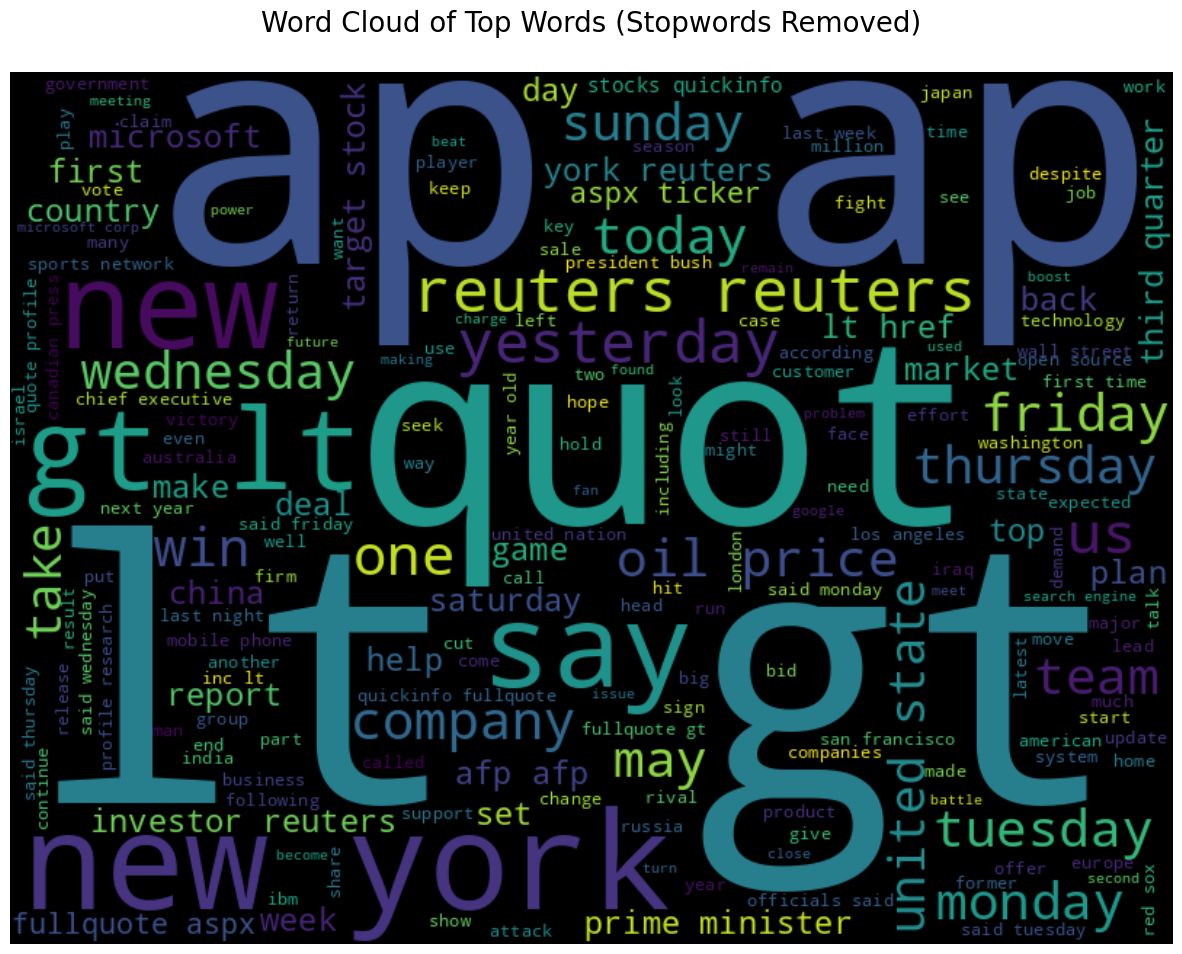

In [19]:
text_for_wordcloud = ' '.join(all_words)
# Create the word cloud object
wordcloud = WordCloud(width=800, height=600, background_color='black').generate(text_for_wordcloud)
# Plot it
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Words (Stopwords Removed)\n', fontsize=20)
plt.show()

# Preprocessing AG News Dataset with Roberta Tokenizer

- Set the base model to `"roberta-base"`.
- Load the corresponding tokenizer from Hugging Face.
- Define a preprocessing function that:
  - Tokenizes the `text` field of dataset examples.
  - Applies truncation and padding to handle varying sequence lengths.
- Use the `map` function to apply preprocessing across the entire dataset in batches.
- Remove the original `text` column after tokenization to keep the dataset tidy.
- The resulting `tokenized_dataset` contains inputs ready for model training or evaluation.


In [20]:

base_model="roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(base_model)
# Define a preprocessing function
def preprocess(examples):
    # Tokenize the text data, truncating and padding sequences
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

# Apply preprocessing to the entire dataset in batches, removing the 'text' column
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])

# Dataset Preparation and Model Setup

- Select 10,000 samples from the training split of the tokenized dataset.
- Check the actual size of the test split and print it for reference.
- Select up to 10,000 samples from the test split, ensuring the selection does not exceed the available size.
- Split the selected test subset into two halves:
  - The first half is used as the evaluation dataset.
  - The second half is reserved as the test dataset.
- Extract the number of classes and their names from the training dataset features.
- Create mappings between label IDs and label names for easy reference.
- Initialize a data collator with padding to dynamically pad batches during training.
- Load a pre-trained sequence classification model (`roberta-base`) with the appropriate label mappings and number of labels.
- Print out the number of labels and the corresponding label names for verification.


In [21]:
# Select 10,000 samples from train split
train_dataset = tokenized_dataset['train'].select(range(10000))

# Get the actual size of the test split
test_size = len(tokenized_dataset['test'])
print(f"Test split size: {test_size}")

# Select samples from test split, ensuring we don't exceed its size
test_subset_size = min(10000, test_size)  # Take at most 10,000, or the full size if smaller
test_subset = tokenized_dataset['test'].select(range(test_subset_size))

# Split the test subset into two halves: eval and test
midpoint = test_subset_size // 2
eval_dataset = test_subset.select(range(midpoint))
test_dataset = test_subset.select(range(midpoint, test_subset_size))

# Extract the number of classes and their names
num_labels = dataset['train'].features['label'].num_classes
class_names = dataset["train"].features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

my_basemodel = AutoModelForSequenceClassification.from_pretrained(
    base_model, 
    id2label=id2label, 
    num_labels=4, 
    label2id=label2id
)
print(f"Number of labels: {num_labels}")
print(f"The labels: {class_names}")

Test split size: 7600


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of labels: 4
The labels: ['World', 'Sports', 'Business', 'Sci/Tech']


# Accuracy Metric Setup for Model Evaluation

- Import the `evaluate` library for metric computation and `numpy` for numerical operations.
- Load the built-in accuracy metric using `evaluate.load("accuracy")`.
- Define a function `compute_metrics` which:
  - Accepts predictions and true labels as input.
  - Uses `np.argmax` to convert model output logits into predicted class indices.
  - Computes accuracy by comparing predicted labels against true references.
  - Returns the accuracy score in the required format for integration with the Trainer.


In [22]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Define Training Arguments for Model Training

- Set `output_dir` to save the trained model and results.
- Use `evaluation_strategy='steps'` to run evaluation periodically during training.
- Set `learning_rate` to 5e-5 for the optimizer’s initial step size.
- Limit training to `num_train_epochs=1` for quick iteration or testing.
- Specify `per_device_train_batch_size=16` to control batch size per GPU.
- These settings provide a consistent training configuration applicable across different models.


In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps", 
    eval_steps=500,  
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    logging_strategy="steps",
    report_to="wandb",
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Trainer Initialization for Model Fine-Tuning

- Instantiate the `Trainer` class with the following parameters:
  - `model`: The pre-trained base model to fine-tune (`my_basemodel`).
  - `args`: Training arguments specifying training configuration (`training_args`).
  - `train_dataset`: The dataset used for training.
  - `eval_dataset`: The dataset used for evaluation during training.
  - `data_collator`: A function to dynamically pad batches (`data_collator`).
  - `compute_metrics`: A callback function to compute evaluation metrics (`compute_metrics`).
  - `processing_class`: The tokenizer to preprocess inputs (`tokenizer`).
  
This setup prepares the Trainer to manage the training loop, evaluation, and logging.


In [24]:
trainer=Trainer(model=my_basemodel,args=training_args,train_dataset=train_dataset,
               eval_dataset=eval_dataset,data_collator=data_collator,
               compute_metrics=compute_metrics,processing_class=tokenizer)

# Start Model Training

- Call `trainer.train()` to begin fine-tuning the model.
- This triggers the training loop using the specified datasets, arguments, and metrics.
- During training, the model parameters are updated, and evaluation is performed according to the configured schedule.
- Training progress, loss, and metrics are logged and can be monitored.


In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy
500,0.165500,0.316221,0.911053


TrainOutput(global_step=625, training_loss=0.35796076469421384, metrics={'train_runtime': 417.2722, 'train_samples_per_second': 23.965, 'train_steps_per_second': 1.498, 'total_flos': 1662118827602688.0, 'train_loss': 0.35796076469421384, 'epoch': 1.0})

In [42]:
trainer.save_model("full_finetune_model")

# PEFT Training

# Setting Up LoRA Fine-Tuning with PEFT

- Load a pre-trained sequence classification model (`my_basemodel`) with the specified number of labels and label mappings.
- Define LoRA configuration parameters (`peft_config`) tailored for sequence classification tasks:
  - `task_type="SEQ_CLS"` specifies the task type.
  - `inference_mode=False` enables training mode.
  - `r=8`, `lora_alpha=16`, and `lora_dropout=0.1` control LoRA’s rank, scaling factor, and dropout rate respectively.
- Apply the LoRA configuration to the base model using `get_peft_model`, creating a parameter-efficient fine-tuning model (`peft_model`).
- Define a helper function `get_trainer` to initialize a Hugging Face `Trainer` with the PEFT model and all necessary components like datasets, tokenizer, data collator, and metrics.
- Print details about which parameters in the PEFT model are trainable to confirm LoRA setup.


In [26]:
my_basemodel = AutoModelForSequenceClassification.from_pretrained(
    base_model, 
    id2label=id2label, 
    num_labels=4, 
    label2id=label2id
)

# Configuring Lora parameters for PEFT (Proxy Experience Finetuning)
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)

# Applying Lora parameters to the model to create the PEFT model
peft_model = get_peft_model(my_basemodel, peft_config)

def get_trainer(model):
    return Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=eval_dataset,
                  data_collator=data_collator,compute_metrics=compute_metrics,processing_class=tokenizer)

# Printing information about the PEFT model's trainable parameters
print('PEFT Model')
peft_model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


# Training the LoRA Fine-Tuned Model

- Obtain a `Trainer` object configured for LoRA fine-tuning by passing the `peft_model` to the `get_trainer` function.
- Call the `.train()` method on the trainer to start the fine-tuning process.
- During training, only the LoRA-adapted parameters are updated, ensuring efficient training with fewer resources.


In [27]:
# Obtaining a trainer object for Lora finetuning
peft_lora_finetuning_trainer = get_trainer(peft_model)
peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
500,0.315000,0.347691,0.885000


TrainOutput(global_step=625, training_loss=0.6177634250640869, metrics={'train_runtime': 322.4375, 'train_samples_per_second': 31.014, 'train_steps_per_second': 1.938, 'total_flos': 1679362625299968.0, 'train_loss': 0.6177634250640869, 'epoch': 1.0})

# Saving the LoRA Fine-Tuned Model and Tokenizer

- Save the fine-tuned LoRA model to the directory `'lora-finetuned-model'` using `save_model()`.
- Save the tokenizer files to the same directory with `save_pretrained()`.
- Keeping both model and tokenizer in the same folder ensures seamless loading for inference or further training.


In [29]:
peft_lora_finetuning_trainer.save_model('lora-finetuned-model')
tokenizer.save_pretrained('lora-finetuned-model')

('lora-finetuned-model/tokenizer_config.json',
 'lora-finetuned-model/special_tokens_map.json',
 'lora-finetuned-model/vocab.json',
 'lora-finetuned-model/merges.txt',
 'lora-finetuned-model/added_tokens.json')

# Loading the Fine-Tuned Model and Defining the Classification Function

- Load the fine-tuned LoRA model from the saved directory `'/kaggle/working/lora-finetuned-model'` with appropriate label mappings.
- Define a `classify` function that:
  - Tokenizes input text with truncation and padding, converting it to PyTorch tensors.
  - Passes the tokenized input through the loaded inference model.
  - Extracts the predicted class index by taking the argmax of the model logits.
  - Prints the predicted class index, corresponding label name, and the input text for clarity.

This setup allows easy testing and inference on new text inputs using the fine-tuned model.


In [37]:
inference_model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/working/lora-finetuned-model", 
    id2label=id2label, 
    num_labels=4, 
    label2id=label2id
)

def classify(text):
    # Tokenize the input text, truncate if needed, pad sequences, and convert to PyTorch tensors
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    # Pass the tokenized input through the inference model to get predictions
    output = inference_model(**inputs)

    # Extract the predicted class index from the model output
    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Example Usage of the Classification Function

- Call the `classify` function with sample texts to get predicted categories.
- Each call tokenizes the input, runs inference, and prints the predicted class index, label, and original text.

Example calls:

```python
classify("Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")

classify("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.")


In [38]:
classify( "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


# Model Evaluation Function Using DataLoader and Accuracy Metric

- Import necessary modules including `DataLoader` for batching, `evaluate` for metric calculation, and `tqdm` for progress bars.
- Load the accuracy metric from the `evaluate` library.
- Define `evaluate_model` function to perform evaluation on a given dataset:
  - Create a `DataLoader` from the dataset, renaming the `"label"` column to `"labels"` to match model input requirements, with batch size 8 and padding handled by `data_collator`.
  - Detect available device (GPU if available, otherwise CPU).
  - Move the inference model to the device and set it to evaluation mode.
  - Iterate through the dataset batches, moving each batch to the device.
  - Perform inference with gradient computation disabled.
  - Extract predicted class indices from the model logits.
  - Add the predictions and true labels to the metric accumulator.
- After all batches, compute and print the overall evaluation metric (accuracy).


In [39]:
# Import necessary modules
from torch.utils.data import DataLoader  # DataLoader for creating data iterators
import evaluate  # Import module for computing evaluation metrics
from tqdm import tqdm  # tqdm for progress tracking during evaluation

# Load the evaluation metric (e.g., accuracy) from the evaluate module
metric = evaluate.load('accuracy')

# Define a function to evaluate the model on a given dataset
def evaluate_model(inference_model, dataset):
    # Create a DataLoader for the evaluation dataset with batch size 8 and using data_collator for batch processing
    eval_dataloader = DataLoader(dataset.rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)
    # Determine the device (GPU or CPU) for model inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the inference model to the appropriate device (GPU or CPU)
    inference_model.to(device)
    # Set the model in evaluation mode (no gradient computation)
    inference_model.eval()

    # Iterate over batches in the evaluation dataloader
    for step, batch in enumerate(tqdm(eval_dataloader)):
        # Move the batch to the device (GPU or CPU)
        batch.to(device)
        # Disable gradient calculation for inference
        with torch.no_grad():
            # Perform inference using the inference model on the batch
            outputs = inference_model(**batch)
        # Extract the predicted class indices from the model outputs
        predictions = outputs.logits.argmax(dim=-1)
        # Assign predictions and reference labels to variables for metric computation
        predictions, references = predictions, batch["labels"]
        # Add the batch of predictions and references to the evaluation metric
        metric.add_batch(predictions=predictions,references=references)

    # Compute the evaluation metric (e.g., accuracy) based on added batches
    eval_metric = metric.compute()
    # Print the computed evaluation metric
    print(eval_metric)



In [40]:
# Evaluate the non fine-tuned model
evaluate_model(AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label,num_labels=4,label2id=label2id), test_dataset)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 475/475 [00:26<00:00, 18.05it/s]

{'accuracy': 0.23921052631578948}


In [43]:
# Evaluate the PEFT fine-tuned model
evaluate_model(inference_model, test_dataset)

100%|██████████| 475/475 [00:27<00:00, 17.25it/s]

{'accuracy': 0.9}


In [44]:
# Evaluate the Fully fine-tuned model
evaluate_model(AutoModelForSequenceClassification.from_pretrained("/kaggle/working/full_finetune_model", id2label=id2label,num_labels=4,label2id=label2id), test_dataset)

100%|██████████| 475/475 [00:26<00:00, 18.05it/s]

{'accuracy': 0.9107894736842105}
